## Analog-to-digital converter errors

MM 5/26/18

This simulates a successive approximation register analog-to-digital converter based on a capacitor array. The goal is to better understand code errors produced due to inaccuracies in the capacitor values.

A good description of how an SAR ADC works, and how one might calibrate it is in: 


Huang XL, Kang PY, Chang HM, Huang JL, Chou YF, Lee YP, et al. A self-testing and calibration method for embedded successive approximation register ADC. 16th Asia and South Pacific Design Automation Conference (ASP-DAC 2011). 2011. pp. 713–718. doi:10.1109/ASPDAC.2011.5722279

Here I simulate an M-bit ADC by choosing the M capacitors. Their values follow a geometric series and each have a small relative error E. The radix of the series, R, is normally supposed to be 2 but can be chosen as something else. Finally the random seed S sets the seed for the simulation.  

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def ADC_Output(M=10, E=0.05, R=2.0, S=0):
    """
    returns the transition voltages for ADC output codes 0 to 2^M-1
    M = number of bits of ADC
    E = SD of relative gaussian error on the capacitor values
    R = radix for the geometric series of capacitor values
    S = random seed for the simulation
    """
    N = 2**M # number of codes
    np.random.seed(S) # random seed to get reproducible results
    im = np.arange(M) # index for the capacitors
    C = np.maximum(R**(-M+im)*np.random.normal(loc=1,scale=E,size=M),0) # capacitor values, powers of R with noise E, positive
    jn = np.arange(N) # index for the codes
    V = np.dot(C,[np.bitwise_and(jn>>i,1) for i in range(M)]) # transition level for each code, using bit field of the code
    for j in range(N-2,0,-1): # from the highest code down...
        V[j] = min(V[j],V[j+1]) # if a transition level is higher than one with a higher code, it merges with the one with the higher code
    return V

Here are 3 simulations with the same parameters, just different random seeds. The plot homes in on the midpoint of the range where one expects the biggest discrepancies based on capacitor value mismatch.

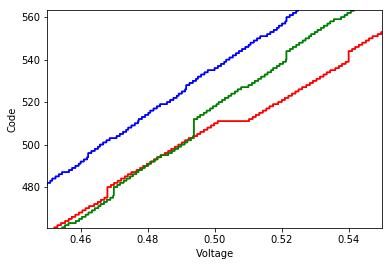

In [15]:
plt.step(ADC_Output(M=10, E=0.05, R=2.0, S=0), range(2**10), where='post', color='r')                             
plt.step(ADC_Output(M=10, E=0.05, R=2.0, S=1), range(2**10), where='post', color='g')                             
plt.step(ADC_Output(M=10, E=0.05, R=2.0, S=2), range(2**10), where='post', color='b')                             
plt.xlim(xmin=0.45, xmax=0.55)                         
plt.ylim(ymin=0.45*2**10, ymax=0.55*2**10)                         
plt.xlabel('Voltage')
plt.ylabel('Code')
plt.show() 

Obviously one can get both missing codes (vertical jumps) and extended codes (wide flat steps). The vertical steps happen when the sum of the first n-1 capacitors is larger than the n-th. The wide horizontal steps happen when it is  smaller than expected.

Missing codes (vertical steps) can be fixed simply by a lookup table. Extended codes (horizontal steps) are more problematic because there the voltage is unknown within a large interval. 

Designers try to avoid extended codes by making the radix for the capacitor array smaller than 2 (this is the factor by which the capacitors increase). That gives a bit of overlap of the capacitor sums, makes missing codes more likely but extended codes less likely. It means the resolution of the output will be less than 1 part in 2^N but avoids localized errors. It also makes it more essential to correct the output for the missing codes.

For example, with R=1.8:

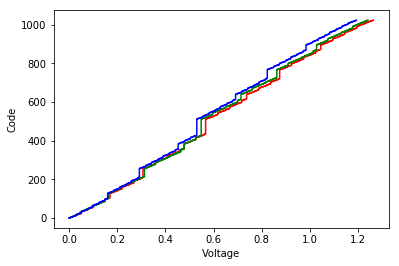

In [10]:
plt.step(ADC_Output(M=10, E=0.05, R=1.8, S=0), range(2**10), where='post', color='r')                             
plt.step(ADC_Output(M=10, E=0.05, R=1.8, S=1), range(2**10), where='post', color='g')                             
plt.step(ADC_Output(M=10, E=0.05, R=1.8, S=2), range(2**10), where='post', color='b')                             
plt.xlabel('Voltage')
plt.ylabel('Code')
plt.show()

…whereas with R=2.2:

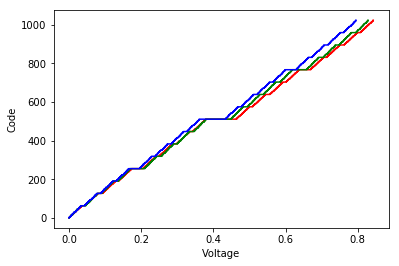

In [12]:
plt.step(ADC_Output(M=10, E=0.05, R=2.2, S=0), range(2**10), where='post', color='r')                             
plt.step(ADC_Output(M=10, E=0.05, R=2.2, S=1), range(2**10), where='post', color='g')                             
plt.step(ADC_Output(M=10, E=0.05, R=2.2, S=2), range(2**10), where='post', color='b')                             
plt.xlabel('Voltage')
plt.ylabel('Code')
plt.show()